In [14]:
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    make_scorer,
)
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    ParameterGrid,
    ParameterSampler,
    RandomizedSearchCV,
)
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor


In [16]:
df = pd.read_json("hh_ru_vacancies.jsonlines", lines=True)
df['salary_mean'] = (df['salary'].apply(lambda x: x.get('from') if isinstance(x, dict) else 0).astype(float) + df['salary'].apply(lambda x: x.get('to') if isinstance(x, dict) else 0).astype(float)) / 2
df.head()

,company_id,vacancy_id,company_nm,vacancy_nm,experience,schedule,work_hours,publication_dt,salary,location,...,similar_ids,current_view_count,scraped_timestamp,metro_line_nm,metro_station_nm,location_lat,location_lon,profession_id,accept_incomplete_resumes,salary_mean
0,11875449.0,127076681,ПрессБук,Электромонтажник ( Челябинск ),between1And3,OTHER,HOURS_10,2025-11-09T17:07:02.523+03:00,"{'from': 165000, 'to': 180000, 'currencyCode':...",Челябинск,...,"[{'company_id': 11875449, 'vacancy_id': 127158...",0,1762736415,None,None,55.159900,61.402550,143,True,172500.0
1,4716984.0,124551351,X5 Digital,Водитель-Курьер в Пятёрочку,noExperience,FLEXIBLE,HOURS_4,2025-10-20T14:05:51.292+03:00,"{'to': 184000, 'currencyCode': 'RUR', 'gross':...","Суслонгер, Первомайская, 1",...,[],0,1762736416,None,None,56.316320,48.256362,58,True,NaN
2,10628995.0,125668881,Финагент,Выездной специалист Альфа-Банка - автокурьер н...,noExperience,SIX_ON_ONE_OFF,HOURS_8,2025-10-23T16:40:30.810+03:00,"{'from': 70000, 'currencyCode': 'RUR', 'gross'...",Юрино,...,"[{'company_id': 80, 'vacancy_id': 126008701}, ...",0,1762736415,None,None,NaN,NaN,58,True,NaN
3,2784143.0,126477226,Птицефабрика Акашевская,Ветеринарный лаборант,noExperience,FIVE_ON_TWO_OFF,HOURS_8,2025-10-13T15:18:57.147+03:00,"{'from': 36200, 'to': 36200, 'currencyCode': '...",посёлок Юбилейный,...,"[{'company_id': 2784143, 'vacancy_id': 1270459...",0,1762736416,None,None,56.748775,48.215968,168,False,36200.0
4,2594000.0,126513468,Племзавод Семёновский,Агроном (Сернурский район),between1And3,SIX_ON_ONE_OFF,HOURS_7,2025-10-14T12:17:59.102+03:00,"{'from': 80000, 'to': 90000, 'currencyCode': '...",деревня Верхний Кугенер,...,[],0,1762736416,None,None,56.891932,49.202695,7,True,85000.0


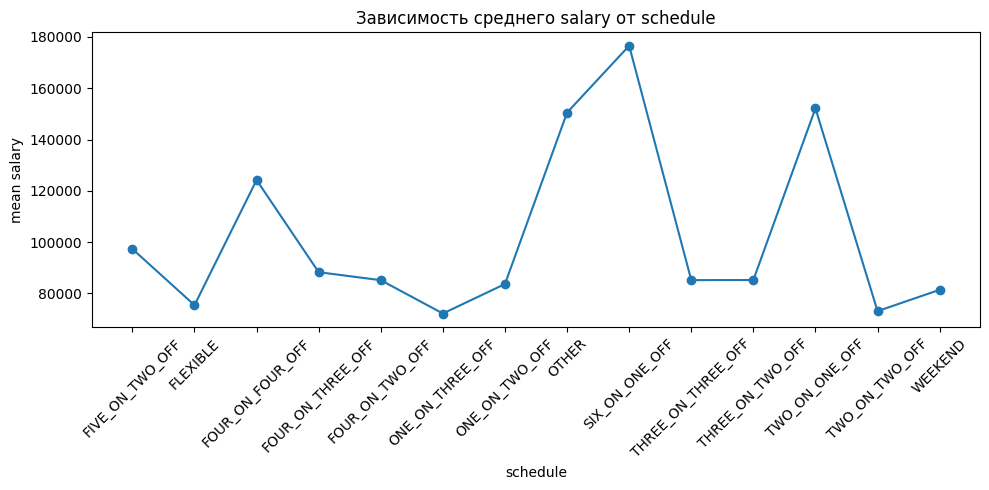

In [17]:
# строим график зависимости среднего зарплаты от schedule
mean_by_schedule = (
    df.groupby('schedule')['salary_mean']
      .mean()
      .reset_index()
)

plt.figure(figsize=(10, 5))
plt.plot(mean_by_schedule['schedule'], mean_by_schedule['salary_mean'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('schedule')
plt.ylabel('mean salary')
plt.title('Зависимость среднего salary от schedule')
plt.tight_layout()
plt.show()

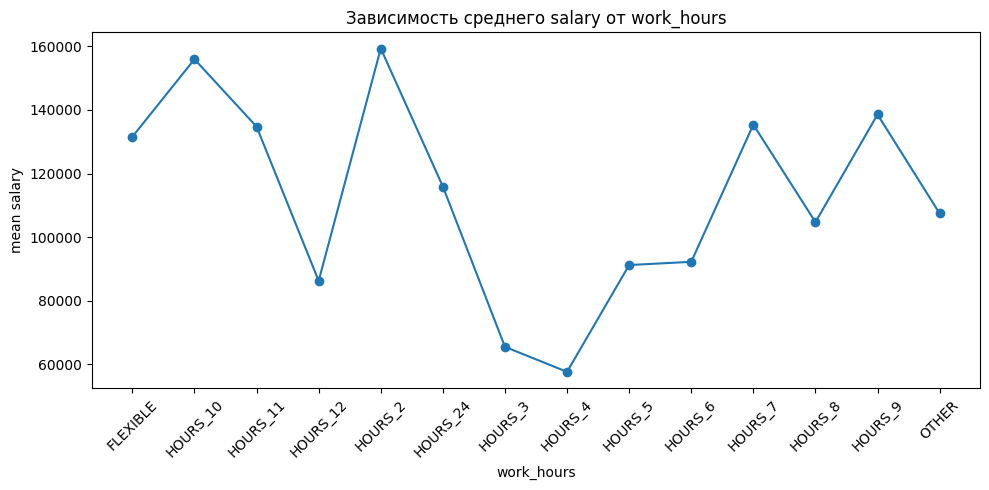

In [18]:
# строим график зависимости среднего зарплаты от work_hours
mean_by_schedule = (
    df.groupby('work_hours')['salary_mean']
      .mean()
      .reset_index()
)

plt.figure(figsize=(10, 5))
plt.plot(mean_by_schedule['work_hours'], mean_by_schedule['salary_mean'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('work_hours')
plt.ylabel('mean salary')
plt.title('Зависимость среднего salary от work_hours')
plt.tight_layout()
plt.show()

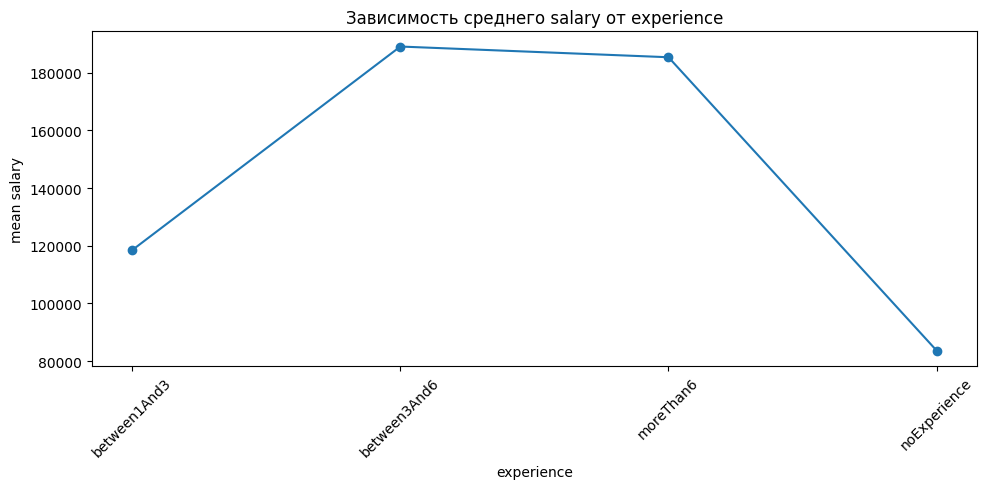

In [19]:
# строим график зависимости среднего зарплаты от experience
mean_by_schedule = (
    df.groupby('experience')['salary_mean']
      .mean()
      .reset_index()
)

plt.figure(figsize=(10, 5))
plt.plot(mean_by_schedule['experience'], mean_by_schedule['salary_mean'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('experience')
plt.ylabel('mean salary')
plt.title('Зависимость среднего salary от experience')
plt.tight_layout()
plt.show()

In [ ]:
# выбор нужных данных для модели
new_df = df[["vacancy_nm", "location", 'experience', 'schedule']].copy()

for c in ["vacancy_nm", "location", 'experience', 'schedule']:
    new_df[c] = new_df[c].fillna('unknown').astype(str)

new_df['work_hours'] = (
    df['work_hours']
    .astype(str)
    .str.extract(r'_(\d+)')[0]
    .fillna(0)
    .astype('float')
)


new_df['salary_from'] = df['salary'].apply(lambda x: x.get('from') if isinstance(x, dict) else 0).astype(float)
new_df['salary_to'] = df['salary'].apply(lambda x: x.get('to') if isinstance(x, dict) else 0).astype(float)
new_df['skills_text'] = df['key_skills'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '').astype(str)


new_df.head(10)


,vacancy_nm,location,experience,schedule,work_hours,salary_from,salary_to,skills_text
0,Электромонтажник ( Челябинск ),Челябинск,between1And3,OTHER,10.0,165000.0,180000.0,
1,Водитель-Курьер в Пятёрочку,"Суслонгер, Первомайская, 1",noExperience,FLEXIBLE,4.0,NaN,184000.0,
2,Выездной специалист Альфа-Банка - автокурьер н...,Юрино,noExperience,SIX_ON_ONE_OFF,8.0,70000.0,NaN,"Пользователь ПК, Грамотная речь, работа с доку..."
3,Ветеринарный лаборант,посёлок Юбилейный,noExperience,FIVE_ON_TWO_OFF,8.0,36200.0,36200.0,
4,Агроном (Сернурский район),деревня Верхний Кугенер,between1And3,SIX_ON_ONE_OFF,7.0,80000.0,90000.0,"Пользователь ПК, Работа в команде, Водительско..."
5,Электромонтажник (г. Лыткарино),Лыткарино,between1And3,OTHER,10.0,168000.0,NaN,
6,Дежурный по железнодорожной станции - Суслонгер,"Суслонгер, Железнодорожная, 13",noExperience,TWO_ON_TWO_OFF,12.0,53000.0,53000.0,
7,Шлифовщик,Ступино,between1And3,SIX_ON_ONE_OFF,12.0,232128.0,NaN,"Точность и внимательность к деталям, Чтение че..."
8,"Менеджер по работе с клиентами, пгт. Сернур","посёлок городского типа Сернур, Советская улиц...",noExperience,TWO_ON_TWO_OFF,8.0,39000.0,NaN,
9,Кладовщик (Казань),Советский (Республика Марий Эл),noExperience,THREE_ON_THREE_OFF,10.0,115000.0,140000.0,


In [ ]:
# уборка пропусков выбросов и аномалии
X = new_df.drop(columns=['salary_from', 'salary_to'])
y = new_df[['salary_from', 'salary_to']]

mask = y['salary_from'].notna() & y['salary_to'].notna()
X_clean = X[mask].reset_index(drop=True)
y_clean = y[mask].reset_index(drop=True)

mask = (y_clean['salary_from'] > 5000) & (y_clean['salary_to'] > 5000)
X_min = X_clean[mask].reset_index(drop=True)
y_min = y_clean[mask].reset_index(drop=True)

q_low = y_min['salary_to'].quantile(0.01)
q_high = y_min['salary_to'].quantile(0.99)

mask_out = (y_min['salary_to'] >= q_low) & (y_min['salary_to'] <= q_high)

X = X_min[mask_out].reset_index(drop=True)
y = y_min[mask_out].reset_index(drop=True)

y_log = np.log1p(y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

X_train2, X_val, y_train2, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)

cat_features_index = [
    X_train2.columns.get_loc(c)
    for c in ['schedule', 'experience', 'location']
]

text_features_index = [
    X_train2.columns.get_loc(c)
    for c in ['vacancy_nm', 'skills_text']
]

In [12]:
# подбор гиперпарметров для модели catboost и создание модели

param_distributions = {
    'depth': [6, 8],
    'learning_rate': [0.03, 0.05],
    'l2_leaf_reg': [3, 5, 7],
    'bagging_temperature': [0.0, 0.5, 1.0],
    'rsm': [0.7, 0.9]
}

best_score = np.inf
best_params = None
best_model = None
sampler = ParameterSampler(param_distributions, n_iter=20, random_state=42)
for params in sampler:
    print("Пробую параметры:", params)

    model = CatBoostRegressor(
        iterations=2000,
        loss_function='MultiRMSE',
        random_state=42,
        verbose=False,
        **params
    )

    model.fit(
        X_train2,
        y_train2,
        cat_features=cat_features_index,
        text_features=text_features_index,
        eval_set=(X_val, y_val),
        use_best_model=True,
        early_stopping_rounds=100
    )

    y_val_pred_log = model.predict(X_val)


    y_val_true = np.expm1(y_val.values)
    y_val_pred = np.expm1(y_val_pred_log)

    mae = mean_absolute_error(y_val_true, y_val_pred)

    print(f"MAE на валидации: {mae:.2f}")

    if mae < best_score: 
        best_score = mae
        best_params = params
        best_model = model

print("\nЛучшие параметры:")
print(best_params)
print("Лучший MAE:", best_score)
model_cat = best_model

Пробую параметры: {'rsm': 0.7, 'learning_rate': 0.03, 'l2_leaf_reg': 5, 'depth': 6, 'bagging_temperature': 0.0}


KeyboardInterrupt: 

In [13]:
y_pred_log = model_cat.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test1 = np.expm1(y_test)

mae = mean_absolute_error(y_test1, y_pred)

rmse = np.sqrt(mean_squared_error(y_test1, y_pred))

mae_from = mean_absolute_error(y_test1.iloc[:,0], y_pred[:,0])
mae_to = mean_absolute_error(y_test1.iloc[:,1], y_pred[:,1])
# метрики
print("MAE (общий):", mae)
print("RMSE (общий):", rmse)
print("MAE salary_from:", mae_from)
print("MAE salary_to:", mae_to)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_from = mape(y_test1.iloc[:, 0].values, y_pred[:, 0])
mape_to = mape(y_test1.iloc[:, 1].values, y_pred[:, 1])

print("MAPE salary_from (%):", mape_from)
print("MAPE salary_to (%):", mape_to)


# Проверка генерализационного разрыва, переобчуения
print("Лучшее количество итераций:", model_cat.tree_count_)
print("валидация:", model_cat.get_best_score()["validation"]["MultiRMSE"])
print("обучение:", model_cat.get_best_score()["learn"]["MultiRMSE"])


CatBoostError: There is no trained model to use predict(). Use fit() to train model. Then use this method.

In [ ]:
model_filename = 'model_catboost_new.cbm'

model_cat.save_model(model_filename)

print(f"Модель успешно сохранена в файл: {model_filename}")

In [11]:
cat_cols = ["vacancy_nm", "location", 'experience', 'schedule', 'skills_text']

num_cols = ["work_hours"]

preprocess = ColumnTransformer(
    transformers=[
        ('cat',
         OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
         cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

xgb_base = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=8,
    objective='reg:squarederror',
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

model_xgb = Pipeline([
    ('prep', preprocess),
    ('reg', MultiOutputRegressor(xgb_base))
])

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

param_distributions = {
    'reg__estimator__learning_rate': np.linspace(0.01, 0.15, 7),
    'reg__estimator__max_depth': [4, 6, 8, 10],
    'reg__estimator__subsample': [0.6, 0.8, 1.0],
    'reg__estimator__colsample_bytree': [0.6, 0.8, 1.0],
    'reg__estimator__reg_lambda': [0.1, 1.0, 5.0],
}

random_search = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=param_distributions,
    n_iter=20,
    scoring=mae_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train2, y_train2)

print("Лучшие параметры:")
print(random_search.best_params_)
print("Лучший MAE:", -random_search.best_score_)
model_xgb = random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

In [ ]:
y_pred_log = model_xgb.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test1 = np.expm1(y_test)

mae = mean_absolute_error(y_test1, y_pred)

rmse = np.sqrt(mean_squared_error(y_test1, y_pred))

mae_from = mean_absolute_error(y_test1.iloc[:,0], y_pred[:,0])
mae_to = mean_absolute_error(y_test1.iloc[:,1], y_pred[:,1])
# метрики
print("MAE (общий):", mae)
print("RMSE (общий):", rmse)
print("MAE salary_from:", mae_from)
print("MAE salary_to:", mae_to)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_from = mape(y_test1.iloc[:, 0].values, y_pred[:, 0])
mape_to = mape(y_test1.iloc[:, 1].values, y_pred[:, 1])

print("MAPE salary_from (%):", mape_from)
print("MAPE salary_to (%):", mape_to)


# Проверка генерализационного разрыва, переобчуения
print("Лучшее количество итераций:", model_cat.tree_count_)
print("валидация:", model_cat.get_best_score()["validation"]["MultiRMSE"])
print("обучение:", model_cat.get_best_score()["learn"]["MultiRMSE"])

In [ ]:
model_filename = 'model_xgboost.cbm'

model_cat.save_model(model_filename)

print(f"Модель успешно сохранена в файл: {model_filename}")